In [9]:
# %%
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plots

from skrvm import RVR
from julearn import run_cross_validation
from sklearn.model_selection import StratifiedKFold

import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

# %%
# matplotlib config
cm_all = pickle.load(open("../data/config/plotting_config.p", "rb"))

# %%
# LOAD DATA
# load and inspect data, set modality
# TODO: stratify by age group (young old, middle old, oldest-old)
# modality = input("Which modality are you analyzing? ")
modality = 'interaction_multip'
database = "3_interaction_multip"
mode = "train"
mri = pd.read_csv('../data/ADNI/test_train_PET.csv')
pet = pd.read_csv('../data/ADNI/test_train_MRI.csv')

mri_train = mri[mri['train'] == True]
pet_train = pet[pet['train'] == True]
mri_train = mri_train.reset_index()
pet_train = pet_train.reset_index()
print(mri_train.shape)
# check that all IDs are the same

# changed "Subject" to "name"
if pet_train['name'].equals(mri_train['name']):
    print("Subjects in two modalities match")

col = mri.columns[4:-23].tolist()
print("First column: {}".format(col[0]) +
      "\n(should be 'X17Networks_LH_VisCent_ExStr_1')" +
      "\nLast column: {}".format(col[-1]) +
      " (should be 'CAU.lh)")


(264, 244)
Subjects in two modalities match
First column: X17Networks_LH_VisCent_ExStr_1
(should be 'X17Networks_LH_VisCent_ExStr_1')
Last column: CAU.lh (should be 'CAU.lh)


In [2]:
# %%
# PREPARATION
rand_seed = 42
num_bins = 5

# define models and model names (some are already included in julearn)
rvr = RVR()

# models to test & names
models = [rvr, 'svm', 'gradientboost']
model_names = ['rvr', 'svm', 'gradientboost']

df_train = pd.DataFrame(pet_train[col].values*mri_train[col].values,
                        columns=col, index=pet_train.index)
df_train = pd.concat([mri_train.drop(col, axis=1), df_train], axis=1)

splits = 5

# model params
model_params = pickle.load(open("../data/config/hyperparams_allmodels.p",
                                "rb"))

# %%
# TRAINING
# train models using 5-fold cross-validation
model_results = []
scores_results = []

for i, (model, params) in enumerate(zip(models, model_params)):
    # split data using age-bins instead of real age
    cv = StratifiedKFold(n_splits=splits).split(df_train[col],
                                                df_train['Ageb'])
    cv = list(cv)
    # run julearn function
    scores, final_model = run_cross_validation(X=col, y='age',
                                               preprocess_X='scaler_robust',
                                               problem_type='regression',
                                               data=df_train,
                                               model=model, cv=cv,
                                               seed=rand_seed,
                                               # confounds='PTGENDER',
                                               model_params=params,
                                               return_estimator='all',
                                               scoring=['r2',
                                                        'neg_mean_absolute_error'])
    model_results.append(final_model.best_estimator_)
    scores_results.append(scores)
    print(model, scores['test_neg_mean_absolute_error'].mean())

RVR() -4.275183044302837
svm -4.312272935355675
gradientboost -4.180258509971938


rvr 2.171133395540262 0.7732814469048311 -0.0005380341600687145
svm 3.3770384770451867 0.41792198128417113 -0.22257107542060237
gradientboost 3.0951178623136277 0.5560194823385365 7.697546304067751e-15


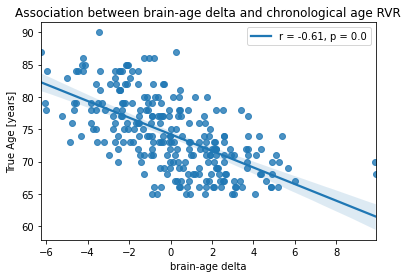

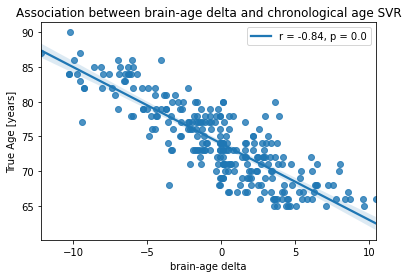

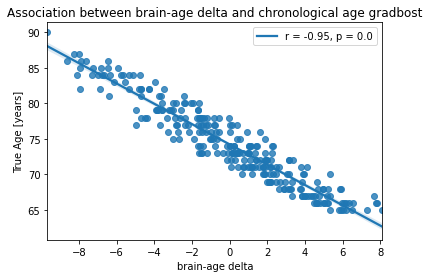

Significant association between RVR-predicted age delta and CA: True
Significant association between SVR-predicted age delta and CA: True
Significant association between gradboost-predicted age delta and CA: True
--- rvr ---
On average, predicted age of 3_interaction_multip differed by -1.5879553564335572e-15 years from their chronological age.
MAE = 1.6861603936941678, R2 = 0.8582165741582374


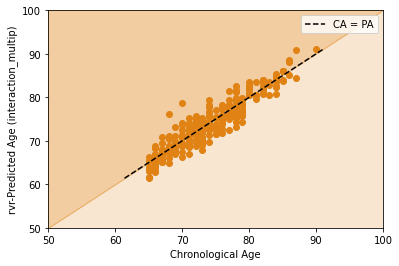

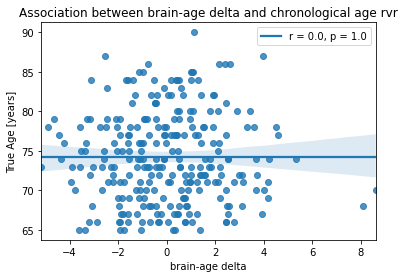

--- svm ---
On average, predicted age of 3_interaction_multip differed by -3.7680296593338647e-16 years from their chronological age.
MAE = 1.8768444951166379, R2 = 0.8265053140650771


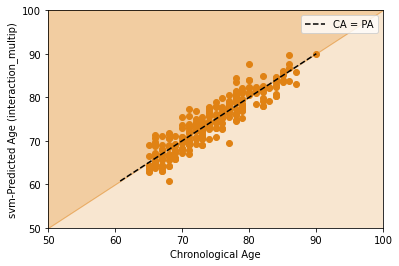

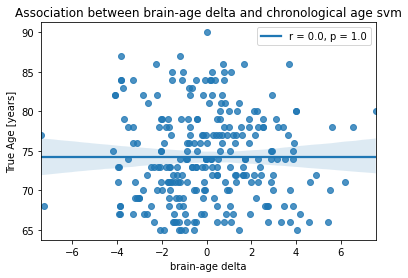

--- gradientboost ---
On average, predicted age of 3_interaction_multip differed by -5.006096547400706e-15 years from their chronological age.
MAE = 0.9342185937077692, R2 = 0.9580070974157806


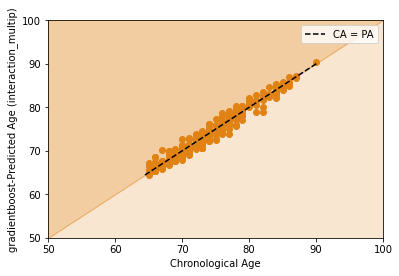

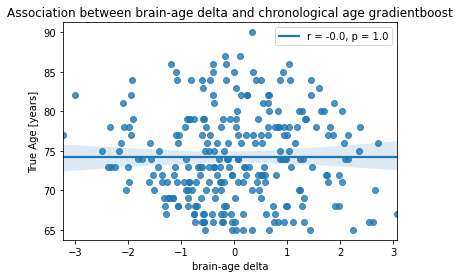

In [10]:
from sklearn.metrics import mean_absolute_error, r2_score
# BIAS CORRECTION DO NOT EXECUTE BEFORE SAVING OTHER RESULTS
y_true = df_train['age']
y_pred_rvr = model_results[0].predict(df_train[col])
y_pred_svr = model_results[1].predict(df_train[col])
y_pred_gb = model_results[2].predict(df_train[col])

pred = [y_pred_rvr, y_pred_svr, y_pred_gb]
for i in range(len(pred)):
    p = pred[i]
    print(model_names[i],
          mean_absolute_error(y_true, p),
          r2_score(y_true, p),
          np.mean(p-y_true))
    

correct_with_CA = True

slope_rvr, intercept_rvr, rvr_check = plots.check_bias(y_true,
                                                       y_pred_rvr,
                                                       'RVR',
                                                       modality,
                                                       database,
                                                       correct_with_CA)
slope_svr, intercept_svr, svr_check = plots.check_bias(y_true,
                                                       y_pred_svr,
                                                       'SVR',
                                                       modality,
                                                       database,
                                                       correct_with_CA)
slope_gb, intercept_gb, gb_check = plots.check_bias(y_true,
                                                    y_pred_gb,
                                                    'gradbost',
                                                    modality,
                                                    database,
                                                    correct_with_CA)

print("Significant association between RVR-predicted age delta and CA:",
      rvr_check)
print("Significant association between SVR-predicted age delta and CA:",
      svr_check)
print("Significant association between gradboost-predicted age delta and CA:",
      gb_check)

# %%
# BIAS CORRECTION
# Eliminate linear correlation of brain age delta and chronological age

# relevance Vectors Regression
y_true = df_train['age']

if correct_with_CA:
    # for age correction WITH chronological age
    y_pred_rvr_bc = y_pred_rvr - (slope_rvr*y_true + intercept_rvr)
    y_pred_svr_bc = y_pred_svr - (slope_svr*y_true + intercept_svr)
    y_pred_gb_bc = y_pred_gb - (slope_gb*y_true + intercept_gb)
else:
    # for age correction WITHOUT chronological age
    y_pred_rvr_bc = (y_pred_rvr - intercept_rvr)/slope_rvr
    y_pred_svr_bc = (y_pred_svr - intercept_svr)/slope_svr
    y_pred_gb_bc = (y_pred_gb - intercept_gb)/slope_gb

pred_bc = [y_pred_rvr_bc, y_pred_svr_bc, y_pred_gb_bc]

for i in range(len(pred_bc)):
    plots.real_vs_pred_2(y_true, pred_bc[i], model_names[i], modality,
                         mode, database_name=database)
    plots.check_bias(y_true, pred_bc[i], model_names[i], modality,
                     database, corrected=True)

# %%
# SAVE MODELS
model_rvr = {'intercept': intercept_rvr,
             'slope': slope_rvr,
             'model': model_results[0]}
model_svr = {'intercept': intercept_svr,
             'slope': slope_svr,
             'model': model_results[1]}
model_gb = {'intercept': intercept_gb,
            'slope': slope_gb,
            'model': model_results[2]}

pickle.dump(model_rvr, open("../results/" + database +
                            "/model_rvr_" + modality +
                            ".p", "wb"))
pickle.dump(model_svr, open("../results/" + database +
                            "/model_svr_" + modality +
                            ".p", "wb"))
pickle.dump(model_gb, open("../results/" + database +
                           "/model_gb_" + modality +
                           ".p", "wb"))
